# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage.io import imread, imshow
from skimage.transform import resize # Using skimage instead of scipy.misc

from PIL import Image
import datetime
import os
import cv2

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

In [4]:
train_doc[0]

'WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

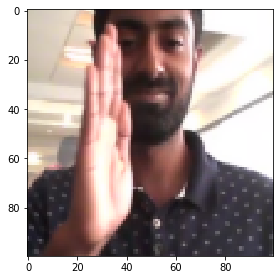

In [5]:
import glob
img = imread(glob.glob(os.path.join("datasets/Project_data/train/", train_doc[263].split(';')[0], '*'))[15])
h = img.shape[0]
imshow(resize(img[75:-75, 50:-50, :], (100,100,3)))

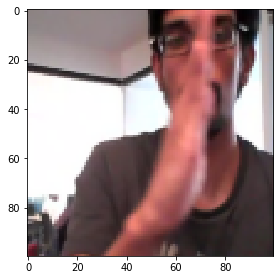

In [6]:
import glob
img = imread(glob.glob(os.path.join("datasets/Project_data/train/", train_doc[173].split(';')[0], '*'))[15])
h = img.shape[0]
imshow(resize(img[75:-75, 50:-50, :], (100,100,3)))

In [44]:
x = 20 # Number of images per video
y = 80 # Height of the image
z = 80 # width of the image

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(6, 24)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z ,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[0]>120:
                        img_crop = image[75:-75, 50:-50, :] # Cropping for 360X360
                    else:
                        img_crop = image[25:-25, 30:-30, :] # Cropping for 120X160
                    
                    final_image = resize(img_crop, (y, z, 3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder, idx, :,:,:] = final_image
                    batch_data[folder,idx,:,:,0] = batch_data[folder,idx,:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = batch_data[folder,idx,:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = batch_data[folder,idx,:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB x,y,z = 18,84,84
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    if image.shape[0]>120:
                        img_crop = image[75:-75, 50:-50, :]
                    else:
                        img_crop = image[25:-25, 30:-30, :]
                    
                    final_image = resize(img_crop, (y, z, 3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder, idx, :,:,:] = final_image
                    
                    batch_data[folder,idx,:,:,0] = batch_data[folder,idx,:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = batch_data[folder,idx,:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = batch_data[folder,idx,:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train/'
val_path = 'datasets/Project_data/val/'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write your model here
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding="same", input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation("elu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3,3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("elu"))
model.add(MaxPooling3D(pool_size=(3,4,4)))

model.add(Flatten())
model.add(Dense(192, activation="elu"))
model.add(Dropout(0.35))
model.add(Dense(5, activation="softmax"))

2023-09-02 04:55:58.788692: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-02 04:55:58.788750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 80, 80, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 20, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 80, 80, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 40, 40, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 40, 40, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 40, 40, 64)   2

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                             save_weights_only=False, mode='auto', save_freq='epoch')
# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train/ ; batch size = 32
Epoch 1/30


2023-09-02 04:56:02.894828: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 3.6171 - categorical_accuracy: 0.2866Source path =  datasets/Project_data/val/ ; batch size = 32

Epoch 00001: saving model to model_init_2023-09-0204_55_58.136552/model-00001-3.61713-0.28658-1.75990-0.26000.h5
21/21 [==============================] - 69s 3s/step - loss: 3.6171 - categorical_accuracy: 0.2866 - val_loss: 1.7599 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5629 - categorical_accuracy: 0.3620
Epoch 00002: saving model to model_init_2023-09-0204_55_58.136552/model-00002-1.56287-0.36199-1.71388-0.25000.h5
21/21 [==============================] - 69s 3s/step - loss: 1.5629 - categorical_accuracy: 0.3620 - val_loss: 1.7139 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.3942 - categorical_accuracy: 0.4465
Epoch 00003: saving model to model_init_2023-09-0204_55_58.136552/model-000

## So the Conv3D Model with 30 epochs gave us train and validation accuracy of 83% and 81% respectively
## Now we'll try with another model
## Tranfer Learning (VGG16) + RNN (GRU)

In [45]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input, TimeDistributed, GlobalAveragePooling2D, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

video = Input(shape=(x, y, z, 3))
cnn_base = VGG16(input_shape=(y, z, 3), weights="imagenet", include_top=False)
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
for i in range(17):
    cnn.layers[i].trainable = False

encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = GRU(256)(encoded_frames)
hidden_layer = Dense(215, activation="relu")(encoded_sequence)
outputs = Dense(5, activation="softmax")(hidden_layer)
model = Model([video], outputs)

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [46]:
optimiser = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20, 80, 80, 3)]   0         
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 512)          14714688  
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 256)               591360    
                                                                 
 dense_13 (Dense)            (None, 215)               55255     
                                                                 
 dense_14 (Dense)            (None, 5)                 1080      
                                                                 
Total params: 15,362,383
Trainable params: 3,007,503
Non-trainable params: 12,354,880
_______________________________________

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [47]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [51]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                             save_weights_only=False, mode='auto', save_freq='epoch')
# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [53]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6155 - categorical_accuracy: 0.2293Source path =  datasets/Project_data/val/ ; batch size = 32

Epoch 00001: saving model to model_init_2023-09-0205_44_57.428028/model-00001-1.61550-0.22926-1.60803-0.20000.h5
21/21 [==============================] - 70s 3s/step - loss: 1.6155 - categorical_accuracy: 0.2293 - val_loss: 1.6080 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5740 - categorical_accuracy: 0.3288
Epoch 00002: saving model to model_init_2023-09-0205_44_57.428028/model-00002-1.57395-0.32881-1.56950-0.24000.h5
21/21 [==============================] - 69s 3s/step - loss: 1.5740 - categorical_accuracy: 0.3288 - val_loss: 1.5695 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.5473 - categorical_accuracy: 0.3288
Epoch 00003: saving model to model_init_2023-09-0205_44_57.42802

## So the Tranfer Learning (VGG16) + RNN (GRU) with 30 epochs gave us train and validation accuracy of 92% and 73% respectively
## Now we'll try with another model
## CNN + RNN (GRU)

In [55]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, Input, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write your model here
video = Input(shape=(x,y,z,3))
cnn_base = Sequential()

cnn_base.add(Conv2D(32, (3,3), activation='elu', padding='same'))
cnn_base.add(BatchNormalization())
cnn_base.add(MaxPooling2D((2,2)))

cnn_base.add(Conv2D(64, (3,3), activation='elu', padding='same'))
cnn_base.add(BatchNormalization())
cnn_base.add(MaxPooling2D((4,4)))

cnn_base.add(Flatten())
cnn_base.add(Dense(128, activation='relu'))
cnn_base.add(Dropout(0.5))

encoded_frames = TimeDistributed(cnn_base)(video)
gru1 = LSTM(256)(encoded_frames)
dropout1 = Dropout(0.5)(gru1)
hidden_layer = Dense(256, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(hidden_layer)
outputs = Dense(5, activation="softmax")(dropout2)
model = Model([video], outputs)

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [57]:
optimiser = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 20, 80, 80, 3)]   0         
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 128)          839104    
 tributed)                                                       
                                                                 
 lstm_3 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                           

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [58]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [59]:
curr_dt_time = datetime.datetime.now()

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False,
                             save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [60]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [61]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train/ ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.7131 - categorical_accuracy: 0.1946Source path =  datasets/Project_data/val/ ; batch size = 32

Epoch 00001: saving model to model_init_2023-09-0206_29_59.011351/model-00001-1.71309-0.19457-1.61061-0.18000.h5
21/21 [==============================] - 70s 3s/step - loss: 1.7131 - categorical_accuracy: 0.1946 - val_loss: 1.6106 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6379 - categorical_accuracy: 0.2247
Epoch 00002: saving model to model_init_2023-09-0206_29_59.011351/model-00002-1.63789-0.22474-1.59803-0.26000.h5
21/21 [==============================] - 68s 3s/step - loss: 1.6379 - categorical_accuracy: 0.2247 - val_loss: 1.5980 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.6157 - categorical_accuracy: 0.2459
Ep

## We tried with 3 different models:
###  - Conv3d with Training Accuracy of 83% & Validation Accuracy of 81%
###  - VGGNet16 + RNN with Training Accuracy of 92% & Validation Accuracy of 73%
###  - CNN + RNN (GRU) with Training Accuracy of 79% &  Validation Accuracy of 62%
### Hence, we'll go with VGG16+RNN(GRU) model as they have lowest cost function for both training/validation (loss: 0.2937/val_loss: 0.5892)